## Classify RNA-Seq + ATAC-Seq by Cell type

In [44]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import h5py
import scanpy as sc
import anndata as ann

# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


In [45]:
# make some fake data until real data becomes available
n_samples, n_rna_features, n_atac_features = 6000, 500, 100
rna_seq_fake = np.random.rand(n_samples, n_rna_features)
atac_seq_fake = np.random.rand(n_samples, n_atac_features)
X_np = np.concatenate([rna_seq_fake, atac_seq_fake], axis=1)
Y_np = np.array(['cell_type_A'] * 2000 + ['cell_type_B'] * 2000 + ['cell_type_C'] * 2000)

In [46]:
# make one-hot encoding of cell type classes
le = LabelEncoder()
Y_le = le.fit_transform(Y_np)
tf.one_hot(Y_le, depth=3)

<tf.Tensor: shape=(6000, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [47]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'UpSampled')
atac_data_path = os.path.join(OUTPUTS, 'atacRaw_upSampled')
rna_data_path = os.path.join(OUTPUTS, 'rnaRaw_upSampled')
bimodal_data_path = os.path.join(OUTPUTS, 'bimodalRaw_upSampled')
bim_low_data_path = os.path.join(OUTPUTS, 'scAI_CellLoad_20Factor_upSampled') # 20 factors

# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
bimodal_df = pd.read_hdf(bimodal_data_path)
bi_low_df = pd.read_hdf(bim_low_data_path)

KeyboardInterrupt: 

In [ ]:
# merge rna and atac together if bimodal dataset not already created
# bimodal_df = pd.merge(rna_df, atac_df, on=['sample', 'treatTime'], suffixes=('_rna', '_atac'))

In [48]:
bimodal_df

Unnamed: 0,sample,treatTime,GPR153,ACOT7,ERRFI1,RP11-431K24.1,RERE,KAZN,TMEM51,IFFO2,...,hs37d5-35343512-35343790,hs37d5-35365182-35365397,hs37d5-35372168-35372717,hs37d5-35383159-35383390,hs37d5-35391131-35391550,hs37d5-35391914-35392213,hs37d5-35408255-35408466,hs37d5-35412204-35412447,hs37d5-35430920-35431120,hs37d5-35431239-35431838
0,sci_RNA_A_001_GACCAATGCG,0,0,0,0,0,2.47697,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sci_RNA_A_001_TCTCTCATCC,0,1.2987,0,0,0,1.84515,0,1.2987,2.19651,...,0,0,0,0,0,0,0,0,0,0
2,sci_RNA_A_002_ATCTAGGTTC,0,0,0,0,0,3.52967,0,0,2.03111,...,0,0,0,0,0,0,0,0,0,0
3,sci_RNA_A_003_ACGTTGAATG,0,0,0,0,0,0,1.5501,1.5501,0,...,0,0,0,0,0,0,0,0,0,0
4,sci_RNA_A_003_CCATCGGACC,0,0,2.71039,0,0,2.71039,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,sci_RNA_E_095_ACGATAGACT,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3221,sci_RNA_E_096_ATATGCCATC,3,0,0,1.96316,0,1.96316,0,1.40141,0,...,0,0,0,0,0,0,0,0,0,0
3222,sci_RNA_E_096_CGAATCTCCT,3,2.01376,0,2.3737,0,2.3737,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3223,sci_RNA_E_096_GGCGGTTGAC,3,0,0,1.10763,0,1.10763,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
atac_df['treatTime'].value_counts()

3    1075
1    1075
0    1075
Name: treatTime, dtype: int64

In [8]:
rna_df['treatTime'].value_counts()

3    1075
1    1075
0    1075
Name: treatTime, dtype: int64

In [9]:
bimodal_df['treatTime'].value_counts()

3    1075
1    1075
0    1075
Name: treatTime, dtype: int64

In [10]:
bi_low_df['treatTime'].value_counts()

3    1075
1    1075
0    1075
Name: treatTime, dtype: int64

**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)

In [12]:
''' Get labels'''
Y_atac = atac_df['treatTime']
Y_rna = rna_df['treatTime']
Y_bimodal = bimodal_df['treatTime']
Y_bi_low = bi_low_df['treatTime']

In [13]:
''' Change to label-encoded values'''
le = LabelEncoder()
Y_atac_le = le.fit_transform(Y_atac) # note that this changes treatment time of 3 to 2, but other labels are the same
Y_rna_le = le.fit_transform(Y_rna)
Y_bimodal_le = le.fit_transform(Y_bimodal)
Y_bi_low_le = le.fit_transform(Y_bi_low)

In [14]:
''' Get feature labels '''
# get features
atac_features = atac_df.iloc[:, 2:].columns
rna_features = rna_df.iloc[:, 2:].columns
bimodal_features = bimodal_df.iloc[:, 2:].columns
bi_low_features = bi_low_df.iloc[:, 2:].columns

# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)
n_bi_low_features = len(bi_low_features)

In [15]:
bimodal_features

Index(['GPR153', 'ACOT7', 'ERRFI1', 'RP11-431K24.1', 'RERE', 'KAZN', 'TMEM51',
       'IFFO2', 'NBL1', 'NBPF3',
       ...
       'hs37d5-35343512-35343790', 'hs37d5-35365182-35365397',
       'hs37d5-35372168-35372717', 'hs37d5-35383159-35383390',
       'hs37d5-35391131-35391550', 'hs37d5-35391914-35392213',
       'hs37d5-35408255-35408466', 'hs37d5-35412204-35412447',
       'hs37d5-35430920-35431120', 'hs37d5-35431239-35431838'],
      dtype='object', name='Unnamed: 0', length=53946)

In [16]:
''' Make matrices into numpy arrays'''
X_atac_np = atac_df.iloc[:, 2:].to_numpy()
X_rna_np = rna_df.iloc[:, 2:].to_numpy()
X_bimodal_np = bimodal_df.iloc[:, 2:].to_numpy()
X_bi_low_np = bi_low_df.iloc[:, 2:].to_numpy()

In [92]:
atac_df.iloc[:,1]

0       0
1       0
2       0
3       0
4       0
       ..
3220    3
3221    3
3222    3
3223    3
3224    3
Name: treatTime, Length: 3225, dtype: int64

In [17]:
''' Get training and TEST sets '''
# TODO - make sure these are stratified
X_train_atac, X_test_atac, Y_train_atac, Y_test_atac = train_test_split(X_atac_np, Y_atac_le, 
                                                                        test_size=0.1, random_state=0, 
                                                                        stratify=Y_atac_le)
X_train_rna, X_test_rna, Y_train_rna, Y_test_rna = train_test_split(X_rna_np, Y_rna_le, 
                                                                    test_size=0.1, random_state=0, 
                                                                    stratify=Y_rna_le)
X_train_bi, X_test_bi, Y_train_bi, Y_test_bi = train_test_split(X_bimodal_np, Y_bimodal_le, 
                                                                test_size=0.1, random_state=0, 
                                                                stratify=Y_bimodal_le)
X_train_bi_low, X_test_bi_low, Y_train_bi_low, Y_test_bi_low = train_test_split(X_bi_low_np, Y_bi_low_le, 
                                                                                test_size=0.1, random_state=0, 
                                                                                stratify=Y_bi_low_le)


In [18]:
''' Get validation sets '''
X_train_atac, X_val_atac, Y_train_atac, Y_val_atac = train_test_split(X_train_atac, Y_train_atac, 
                                                                        test_size=0.11, random_state=1, 
                                                                        stratify=Y_train_atac)
X_train_rna, X_val_rna, Y_train_rna, Y_val_rna = train_test_split(X_train_rna, Y_train_rna, 
                                                                    test_size=0.11, random_state=1, 
                                                                    stratify=Y_train_rna)
X_train_bi, X_val_bi, Y_train_bi, Y_val_bi = train_test_split(X_train_bi, Y_train_bi, 
                                                                test_size=0.11, random_state=1, 
                                                                stratify=Y_train_bi)
X_train_bi_low, X_val_bi_low, Y_train_bi_low, Y_val_bi_low = train_test_split(X_train_bi_low, Y_train_bi_low, 
                                                                                test_size=0.11, random_state=1, 
                                                                                stratify=Y_train_bi_low)

In [25]:
X_train_bi.shape, X_test_bi.shape, X_val_bi.shape

((2582, 53946), (323, 53946), (320, 53946))

In [26]:
''' Make Y labels one-hot '''
# training sets
Y_atac_train = tf.one_hot(Y_train_atac, depth=3)
Y_rna_train = tf.one_hot(Y_train_rna, depth=3)
Y_bimodal_train = tf.one_hot(Y_train_bi, depth=3)
Y_bi_low_train = tf.one_hot(Y_train_bi_low, depth=3)

# validation sets
Y_atac_val = tf.one_hot(Y_val_atac, depth=3)
Y_rna_val = tf.one_hot(Y_val_rna, depth=3)
Y_bimodal_val = tf.one_hot(Y_val_bi, depth=3)
Y_bi_low_val = tf.one_hot(Y_val_bi_low, depth=3)

# test sets
Y_atac_test = tf.one_hot(Y_test_atac, depth=3)
Y_rna_test = tf.one_hot(Y_test_rna, depth=3)
Y_bimodal_test = tf.one_hot(Y_test_bi, depth=3)
Y_bi_low_test = tf.one_hot(Y_test_bi_low, depth=3)

In [27]:
''' Make sure np arrays are float32 before converting to tensors '''
# training sets
X_train_atac = np.asarray(X_train_atac).astype(np.float32)
X_train_rna = np.asarray(X_train_rna).astype(np.float32)
X_train_bi = np.asarray(X_train_bi).astype(np.float32)
X_train_bi_low = np.asarray(X_train_bi_low).astype(np.float32)


# validation sets
X_val_atac = np.asarray(X_val_atac).astype(np.float32)
X_val_rna = np.asarray(X_val_rna).astype(np.float32)
X_val_bi = np.asarray(X_val_bi).astype(np.float32)
X_val_bi_low = np.asarray(X_val_bi_low).astype(np.float32)


# test sets
X_test_atac = np.asarray(X_test_atac).astype(np.float32)
X_test_rna = np.asarray(X_test_rna).astype(np.float32)
X_test_bi = np.asarray(X_test_bi).astype(np.float32)
X_test_bi_low = np.asarray(X_test_bi_low).astype(np.float32)

In [28]:
X_train_atac.shape, X_train_rna.shape, X_train_bi.shape, X_train_bi_low.shape

((2582, 52761), (2582, 1185), (2582, 53946), (2582, 20))

In [29]:
''' Make matrices into TF tensors'''
# training sets
X_atac_train = tf.convert_to_tensor(X_train_atac)
X_rna_train = tf.convert_to_tensor(X_train_rna)
X_bimodal_train = tf.convert_to_tensor(X_train_bi)
X_bi_low_train = tf.convert_to_tensor(X_train_bi_low)

# validation sets
X_atac_val = tf.convert_to_tensor(X_val_atac)
X_rna_val = tf.convert_to_tensor(X_val_rna)
X_bimodal_val = tf.convert_to_tensor(X_val_bi)
X_bi_low_val = tf.convert_to_tensor(X_val_bi_low)


# test sets
X_atac_test = tf.convert_to_tensor(X_test_atac)
X_rna_test = tf.convert_to_tensor(X_test_rna)
X_bimodal_test = tf.convert_to_tensor(X_test_bi)
X_bi_low_test = tf.convert_to_tensor(X_test_bi_low)

In [30]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [500, 500, 2000]
OUTPUT_DIM = 3

def nn_model(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [31]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [50, 50, 200]
OUTPUT_DIM = 3

def nn_model_factor(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [32]:
''' Give summary of architecture '''
n_features = len(bimodal_features)
model = nn_model_factor(n_features, dropout_rate=0.2, l2_lambda=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2697350   
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               10200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6

In [33]:
def sample_shuffle_data(arrays, n_samples=None):
    """subsamples examples from a list of datasets
    
    samples `n_samples` without replacement from along the first dimension
    of each array in `arrays`. The same first-dimension slices are 
    selected for each array in `arrays`.
    
    Arguments:
      arrays: the arrays to be sliced, all must have the same size along 
        their first dimension.
      n_samples: (None) the number of samples to be selected, `n_samples` must 
        be less than or equal to the length of the arrays. If n_samples it not
        passed or is `None`. Then each array in `arrays` will be 
        shuffled in the same way and returned.
      
    Returns:
      sampled: a `tuple` of len the same as `len(arrays)` where each
        element is an array of len `n_samples`
    """
    batch_len = arrays[0].shape[0]
    n_samples = batch_len if n_samples is None else n_samples

    err_msg = 'all arrays must have the same size along their first dimension'
    assert all(batch_len == x.shape[0] for x in arrays), err_msg 
    err_msg = 'n cannot be greater then the length of the arrays'
    assert n_samples <= batch_len, err_msg

    sampling_idxs = tf.random.shuffle(tf.range(batch_len))[:n_samples]
    sampled = tuple(tf.gather(x, sampling_idxs, axis=0) for x in arrays)
    
    return sampled

In [34]:
''' Train step '''
def train_step(model, loss, optimizer, x_batch, y_batch):
    """
    Performs one training step on a model given a loss, optimizer, inputs,
    and labels.
    
    Arguments:
      model: the model on which the pass will be performed
      loss: the loss function to be evaluated, from which the gradients will be
        computed
      optimizer: a `tf.optimizers` object defining the optimization scheme
      x_batch: model training inputs
      y_batch: model training labels
      
    Returns:
      loss_value: the computed loss for the forward training pass
    """
#     print('X_batch : {} \n y_batch : {}'.format(x_batch, y_batch))
    with tf.GradientTape() as tape:
#         print(f'x_batch: {x_batch}')
#         print(f'y_batch: {y_batch}')

        y_batch_pred = model(x_batch, training=True)
        loss_value = loss(y_batch, y_batch_pred)
#         print(f"model losses type: {model.losses}")
        loss_value += sum(model.losses)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss_value

In [35]:
''' Training Loop '''
def training(x_train, y_train, x_val, y_val, hyperparam_config, num_epochs, batch_size,
             save_model=True, model_dir='models/best_model'):  
    
    """
    Train a fully-connected network to classify rna_seq + atac-seq by cell type
    
    Arguments:
      x_train: input training set
      y_train: label training set
      x_val: input validation set
      y_val: label validation set
      hyperparam_config: a dictionary that stores a hyperparameter configuration,
                         including:
                           - "dropout_rate": dropout rate (1 - keep probability),
                           - "l2": coefficient lambda for L2 regularization,
                           - "lr": learning rate for RMSProp optimizer
      num_epochs: number of epochs to train
      batch_size: training mini-batch size (must be same as the batch size for pairwise P calculation)
      save_model: whether or not to save the best model based on the validation loss
      model_dir: location where model will be saved
    
    Returns:
      best_loss: best validation loss
      best_kl_div: validation KL loss from the epoch that has best validation loss
    """
    
    ################################################################################
    # Make sure to wrap train_step with tf.function to speed up training!
    train_fn = tf.function(train_step)
#     train_fn = train_step
    ################################################################################ 
    
    ######################## BEGIN YOUR ANSWER ########################
    # get num_batches
    num_samples, num_features = x_train.shape
    num_batches = np.floor(num_samples) // batch_size
    
    # initalize model, loss, and optimizers
    dropout_rate = hyperparam_config['dropout_rate']
    l2_lambda = hyperparam_config['l2_lambda']
    lr = hyperparam_config['lr']
    model = nn_model(n_features=num_features, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
    loss_fn = tf.keras.losses.CategoricalCrossentropy() # todo - make sure this is correct
    optimizer = K.optimizers.SGD(learning_rate=lr)  #TODO - double check this optimizer

    
    # Get initial loss for comparison 
    print('getting initial loss')
    best_loss = loss_fn(y_val, model(x_val))
    
    # init progress bars
    epoch_pbar = tqdm(total=num_epochs, desc="Training Epochs")
    batch_pbar = tqdm(desc="Training Steps")
    
    
    n = x_train.shape[0]
    # for each epoch   
    # start training loop 
    for epoch in range(num_epochs):
        # shuffle data
        if epoch >= 1: x_train, y_train = sample_shuffle_data([x_train, y_train], num_samples)
        
        batch_pbar.reset(num_batches)
        for step in range(int(num_batches)):
            # getting indices of batches to train on
            range_begin = (step * batch_size) % (x_train.shape[0] - batch_size) #taking mod to prevent ix errors
            range_end = range_begin + batch_size
            batch_x = x_train[range_begin:range_end, :]
            batch_y = y_train[range_begin:range_end, :]
            epoch_loss = train_fn(model, loss_fn, optimizer,
                                 batch_x, batch_y)
  
            
            batch_pbar.update()
    
        # compute and print loss on validation data
        val_loss = loss_fn(y_val, model(x_val)) #note - don't need reg_coeff defined because already defined using functools.partial
        
        if epoch%5 ==0:
            tf.print("epoch: {:02d}, loss: {:5.3f}".format(epoch, val_loss))
        
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                # if directory hasn't been created, create it
                if not os.path.isdir('models'):
                    !mkdir -p models
                # if model has already been saved, remove folder and save again
                if os.path.isdir(model_dir):
                    shutil.rmtree(model_dir)
                # make directory again and save
#                 !mkdir -p models/best_loss
                model.save(model_dir)
        batch_pbar.refresh()
        epoch_pbar.update()
            
                
    ######################### END YOUR ANSWER #########################
    
    
    return best_loss


In [36]:
''' Get useful parameters for defining architecture '''
X_shape = tf.shape(X_bimodal_train)
assert len(X_shape) == 2, f'Order of input tensor shoud be 2 but is {len(X_shape)}'
num_cells, num_features = X_shape
dropout_rate = 0.1
l2_lambda = 1e-6
learning_rate = 0.001

In [37]:
Y_atac_test;

In [38]:
n_epochs = 50

In [39]:
''' This cell will train the model on a given set of hyperparameters. This code is repeated later'''
''' Train model using ATAC-seq as features'''
# define hyperparameters
run_cell=False
if run_cell:
    hyperparams_atac = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}


    training(X_atac_train, Y_atac_train, X_atac_test, Y_atac_test, 
             hyperparam_config=hyperparams_atac,
            num_epochs=n_epochs,
            batch_size=100,
            save_model=True,
            model_dir=f'models/atac_only_model_{n_epochs}_epochs')

    ''' Train model using RNA-seq as features'''
    # define hyperparameters
    hyperparams_rna = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_rna_train, Y_rna_train, X_rna_test, Y_rna_test, 
             hyperparam_config=hyperparams_rna,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/rna_only_model_{n_epochs}_epochs')

    ''' Train model using both ATAC and RNA as features'''
    # define hyperparameters
    hyperparams_bimodal = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test, 
             hyperparam_config=hyperparams_bimodal,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/bimodal_model_{n_epochs}_epochs')

## Hyperparameter tuning

In [40]:
''' Hyperparameter search using validation set'''
def grid_search(x_train, y_train, dropout_rates, l2_lambdas, learning_rates, num_epochs=40, batch_size=300):
    """
    Perform grid search for the best tSNE hyperparameters
    
    Arguments:
      x_train: input training set
      y_train: label training set
      dropout_rates: dropout rates to try
      l2_lambdas: L2 lambda coefficients to try
      learning_rates: learning rates to try
      num_epochs: number of epochs to train
      batch_size: training mini-batch size
    
    Returns:
      losses: list losses for configurations tested where
        losses[i] = [dropout_rate, l2_lambda, learning_rate, best_loss, best_kl_divgergence]
    """
    losses = []
    
    pbar = tqdm(total = len(dropout_rates) * len(l2_lambdas) * len(learning_rates))
    for dropout_rate in dropout_rates:
        for l2_lambda in l2_lambdas:
            for learning_rate in learning_rates:
                print("training with dropout:{} l2:{} lr:{}".format(dropout_rate,l2_lambda,learning_rate))
                # DO NOT shuffle your validation/train set because the pairwise label are calculated by batch
                # Use the last batch in train set as the validation set
                subset_x_train, subset_y_train=(x_train[0:-batch_size],y_train[0:-batch_size])
                subset_x_val, subset_y_val = (x_train[-batch_size:],y_train[-batch_size:])
                hyperparam_config = {'dropout_rate': dropout_rate,
                                     'l2_lambda': l2_lambda,
                                     'lr': learning_rate}

                best_loss = training(subset_x_train, subset_y_train,
                                     subset_x_val, subset_y_val,
                                     hyperparam_config,
                                     num_epochs,
                                     batch_size,
                                     save_model=False)

                losses.append([dropout_rate, l2_lambda, learning_rate, best_loss])
                pbar.update(1)
    pbar.close()
    return losses


In [41]:
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
NUM_EPOCHS = 10
BATCH_SIZE = 64

In [42]:
''' GRID-SEARCH for ATAC-seq as input'''
atac_param_result = grid_search(X_atac_train, Y_atac_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.103
epoch: 05, loss: 1.058
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.121
epoch: 05, loss: 1.119
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.077
epoch: 05, loss: 1.077
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.065
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.091
epoch: 05, loss: 1.091
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.102
epoch: 05, loss: 1.102
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.104
epoch: 05, loss: 1.052
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.086
epoch: 05, loss: 1.087
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.111
epoch: 05, loss: 1.111
training with dropout:0.2 l2:1e-06 lr:0.1

getting initial loss


epoch: 00, loss: 1.115
epoch: 05, loss: 1.137
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss











epoch: 00, loss: 1.101
epoch: 05, loss: 1.103
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.112
epoch: 05, loss: 1.112
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.107
epoch: 05, loss: 1.213
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.101
epoch: 05, loss: 1.102
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.094
epoch: 05, loss: 1.094
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.094
epoch: 05, loss: 1.285
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.103
epoch: 05, loss: 1.103
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.096
epoch: 05, loss: 1.096



In [43]:
''' GRID-SEARCH with RNA-seq as input'''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
rna_param_result = grid_search(X_rna_train, Y_rna_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.091
epoch: 05, loss: 1.077
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.119
epoch: 05, loss: 1.095
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.124
epoch: 05, loss: 1.119
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.104
epoch: 05, loss: 0.962
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.168
epoch: 05, loss: 1.107
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.105
epoch: 05, loss: 1.105
training with dropout:0.2 l2:0.001 lr:0.1

getting initial loss


epoch: 00, loss: 1.116
epoch: 05, loss: 1.055
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.144
epoch: 05, loss: 1.096
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.083
epoch: 05, loss: 1.083
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.044
epoch: 05, loss: 0.927
training with dropout:0.2 l2:1e-06 lr:0.01

getting initial loss


epoch: 00, loss: 1.162
epoch: 05, loss: 1.064
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss





epoch: 00, loss: 1.155
epoch: 05, loss: 1.155
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.144
epoch: 05, loss: 0.873
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.093
epoch: 05, loss: 1.044
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.149
epoch: 05, loss: 1.149
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.052
epoch: 05, loss: 0.917
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.102
epoch: 05, loss: 1.072
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.115
epoch: 05, loss: 1.115



In [31]:
''' GRID-SEARCH with bimodal input '''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bimodal_param_result = grid_search(X_bimodal_train, Y_bimodal_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.100
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.100
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.099
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss
























epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.100
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.102
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099



In [39]:
''' GRID-SEARCH with low-dimensional bimodal input '''
run_cell = False
if run_cell:
    dropout_rates = [0.5, 0.2, 0.1]
    l2_lambdas = [1e-03, 1e-06]
    learning_rates = [0.1, 0.01, 1e-4]
    bi_low_param_result = grid_search(X_bi_low_train, Y_bi_low_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.103
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.102
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.100
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss




epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.099
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.100
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099



In [113]:
''' Visualize ATAC-seq grid search'''
param_result_eval = atac_param_result.copy()
for i, row in enumerate(atac_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            param_result_eval[i][j] = val
            

atac_grid_search_df = pd.DataFrame(param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
atac_grid_search_pivot = (atac_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
atac_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [114]:
''' Visualize RNA-seq grid search'''
rna_param_result_eval = rna_param_result.copy()
for i, row in enumerate(rna_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            rna_param_result_eval[i][j] = val
            
rna_grid_search_df = pd.DataFrame(rna_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
rna_grid_search_pivot = (rna_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
rna_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [32]:
''' Visualize Bimodal grid search'''
bimodal_param_result_eval = bimodal_param_result.copy()
for i, row in enumerate(bimodal_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bimodal_param_result_eval[i][j] = val
            
bimodal_grid_search_df = pd.DataFrame(bimodal_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bimodal_grid_search_pivot = (bimodal_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bimodal_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [116]:
''' Visualize low-dimensional Bimodal grid search'''
run_cell = False
if run_cell:
    bi_low_param_result_eval = bi_low_param_result.copy()
    for i, row in enumerate(bi_low_param_result):
        for j, v in enumerate(row):
            if isinstance(v, tf.Tensor):
                val = tf.keras.backend.eval(v)
                bi_low_param_result_eval[i][j] = val

    bi_low_grid_search_df = pd.DataFrame(bi_low_param_result_eval, 
                                 columns=['dropout rate',
                                          'L2 lambda',
                                          'learning rate',
                                          'validation loss'])
    bi_low_grid_search_pivot = (bi_low_grid_search_df
                         .pivot_table(values=['validation loss'],
                                      columns=['L2 lambda'],
                                      index=['learning rate', 'dropout rate']))
    bi_low_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                                 axis=None)

In [289]:
''' Predict using validation or test set '''

' Predict using validation or test set '

In [117]:
BEST_MODEL_DIR = os.path.join('models', 'best_atacSVD_upSampled_model')
NUM_EPOCHS = 100
ATAC_BATCH_SIZE = 64
# Define hyperparam_config e.g.

######################## BEGIN YOUR ANSWER ########################
atac_hyperparam_config = {'dropout_rate': 0.2,
                     'l2_lambda': 0.001,
                     'lr': 0.1}
######################### END YOUR ANSWER #########################

atac_test_loss = training(
    X_atac_train, Y_atac_train, X_atac_test, Y_atac_test,
    atac_hyperparam_config, NUM_EPOCHS, ATAC_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)


getting initial loss


epoch: 00, loss: 0.914
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
epoch: 05, loss: 0.816
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
epoch: 10, loss: 0.775
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_atacSVD_upSampled_model/as

In [118]:
BEST_MODEL_DIR = os.path.join('models', 'best_rnaPCA_upSampled_model')
RNA_BATCH_SIZE = 64

rna_hyperparam_config = {'dropout_rate': 0.2,
                     'l2_lambda': 0.001,
                     'lr': 0.1}

rna_test_loss = training(
    X_rna_train, Y_rna_train, X_rna_test, Y_rna_test,
    rna_hyperparam_config, NUM_EPOCHS, RNA_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss


epoch: 00, loss: 0.313
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
epoch: 05, loss: 0.199
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
epoch: 10, loss: 0.178
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
epoch: 15, loss: 0.179
epoch: 20, loss: 0.191
INFO:tensorflow:Assets written to: models/best_rnaPCA_upSampled_model/assets
epoch: 25, loss: 0.186
epoch: 30, loss: 0.195
epoch: 35, loss: 0.191
epoch: 40, loss: 0.187
epoch: 45, loss: 0.194


In [34]:
BEST_MODEL_DIR = os.path.join('models', 'best_bimodal_cellLoad_upSampled_model')
NUM_EPOCHS = 100
BIMODAL_BATCH_SIZE = 64

bimodal_hyperparam_config = {'dropout_rate': 0.5,
                     'l2_lambda': 0.001,
                     'lr': 0.1}

bimodal_test_loss = training(
    X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test,
    bimodal_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.099
epoch: 10, loss: 1.099
epoch: 15, loss: 1.099
epoch: 20, loss: 1.099
epoch: 25, loss: 1.099
epoch: 30, loss: 1.099
epoch: 35, loss: 1.099
epoch: 40, loss: 1.099
epoch: 45, loss: 1.099
epoch: 50, loss: 1.099
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/best_bimodal_cellLoad_upSampled_model/assets
epoch: 55, loss: 1.099
INFO:tensorflow:Assets written to: models/best_bimodal_cellLoad_upSampled_model/assets
epoch: 60, loss: 1.099
epoch: 65, loss: 1.099
epoch: 70, loss: 1.099
epoch: 75, loss: 1.099
epoch: 80, loss: 1.099
epoch: 85, loss: 1.099
epoch: 90, loss: 1.099
epoch: 95, loss: 1.099


In [294]:
BEST_MODEL_DIR = os.path.join('models', 'best_factor2_model_pp_fs')
BIMODAL_BATCH_SIZE = 64

bi_low_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': 1e-06,
                     'lr': 0.1}

bi_low_test_loss = training(
    X_bi_low_train, Y_bi_low_train, X_bi_low_test, Y_bi_low_test,
    bi_low_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)









Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]








Training Steps: 0it [00:00, ?it/s]








Training Steps:   0%|          | 0/37.0 [00:00<?, ?it/s]

getting initial loss











Training Steps:   3%|▎         | 1/37.0 [00:00<00:09,  3.78it/s]

epoch: 00, loss: 1.067
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   1%|          | 1/100 [00:00<01:28,  1.12it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   2%|▏         | 2/100 [00:01<01:19,  1.23it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 05, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   6%|▌         | 6/100 [00:01<00:54,  1.73it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  10%|█         | 10/100 [00:01<00:37,  2.42it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 10, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  14%|█▍        | 14/100 [00:01<00:25,  3.35it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 15, loss: 1.066
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  17%|█▋        | 17/100 [00:02<00:22,  3.62it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 20, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  21%|██        | 21/100 [00:02<00:15,  4.94it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  25%|██▌       | 25/100 [00:02<00:11,  6.64it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 25, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  29%|██▉       | 29/100 [00:02<00:08,  8.69it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 30, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  33%|███▎      | 33/100 [00:03<00:05, 11.21it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 35, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  37%|███▋      | 37/100 [00:03<00:04, 14.02it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 40, loss: 1.066
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  41%|████      | 41/100 [00:03<00:06,  9.55it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  45%|████▌     | 45/100 [00:04<00:04, 12.18it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 45, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  49%|████▉     | 49/100 [00:04<00:03, 15.09it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 50, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  53%|█████▎    | 53/100 [00:04<00:02, 18.10it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 55, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  57%|█████▋    | 57/100 [00:04<00:02, 21.02it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 60, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  61%|██████    | 61/100 [00:04<00:01, 23.71it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  65%|██████▌   | 65/100 [00:04<00:01, 25.82it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 65, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  69%|██████▉   | 69/100 [00:04<00:01, 27.52it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 70, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  73%|███████▎  | 73/100 [00:04<00:00, 28.72it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 75, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  77%|███████▋  | 77/100 [00:04<00:00, 29.91it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 80, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  81%|████████  | 81/100 [00:05<00:00, 30.89it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  85%|████████▌ | 85/100 [00:05<00:00, 31.81it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 85, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  89%|████████▉ | 89/100 [00:05<00:00, 32.57it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 90, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  93%|█████████▎| 93/100 [00:05<00:00, 32.31it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 95, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  97%|█████████▋| 97/100 [00:05<00:00, 32.65it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]

## Evaluate model performance

In [35]:
def predict_one_hot(x, model_dir):
    """
    Load a trained model and predict class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
      y_output: one_hot representation of model output where argmax 
                is just chosen as class
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)
    
    #convert to one-hot representation
    y_output = tf.one_hot(tf.nn.top_k(y_pred).indices, tf.shape(y_pred)[1])
    
    return tf.squeeze(y_output)


def predict(x, model_dir):
    """
    Load a trained model and predict probability for each class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
        y_output: softmax rep of class labels
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)

    return y_pred

In [36]:
def get_labels_from_one_hot(one_hot_labels):
    ''' Get labels from one-hot encoding '''
    return np.argmax(one_hot_labels.numpy(), axis=1)

In [37]:
def accuracy(y_true, y_pred):
    ''' Computes accuracy '''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(y_true, y_pred )
    return acc.result().numpy()


def precision(y_true, y_pred):
    ''' Computes precision '''
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true, y_pred)
    return prec.result().numpy()
    
    
def recall(y_true, y_pred):
    ''' Computes recall'''
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true, y_pred)
    return rec.result().numpy()


def TPR(y_true, y_pred, thresholds=None):
    ''' Computes True positive rate '''
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    return tp.result().numpy()


def FPR(y_true, y_pred, thresholds=None):
    ''' Computes false positive rate '''
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    return fp.result().numpy()


#TODO - confusion matrix


def compute_ROC_curve(y_true, y_pred):
    pass

In [38]:
def make_confusion_matrix_DEX(y_test, y_pred, cmap='Blues', subtitle='INSERT SUBTITLE'):
    y_true_labeled = get_labels_from_one_hot(y_test)
    y_pred_labeled = get_labels_from_one_hot(y_pred)
    conf_matrix = tf.math.confusion_matrix(y_true_labeled, y_pred_labeled, dtype=tf.dtypes.int64).numpy()
    fig, axs = plt.subplots(1)
    sns.heatmap(conf_matrix,annot=True, cmap=cmap, 
                xticklabels=['0 hr', '1 hr', '3 hrs'],
               yticklabels=['0 hr', '1 hr', '3 hrs'],
               ax=axs);
    subtitle = subtitle
    axs.set_title(f'Confusion Matrix\n{subtitle}')

In [124]:
''' Evaluate model trained ONLY on ATAC-seq input '''
y_atac_pred = predict_one_hot(X_atac_test, model_dir='models/best_atacSVD_upSampled_model')
y_atac_sm = predict(X_atac_test, model_dir='models/best_atacSVD_upSampled_model')

In [125]:
''' Get metrics for ATAC-seq'''
print(f'Accuracy: {accuracy(Y_atac_test, y_atac_pred)}')
print(f'Precision: {precision(Y_atac_test, y_atac_pred)}')
print(f'Recall: {precision(Y_atac_test, y_atac_pred)}')
FPR(Y_atac_test, y_atac_sm)

Accuracy: 0.7708978056907654
Precision: 0.6563467383384705
Recall: 0.6563467383384705


97.0

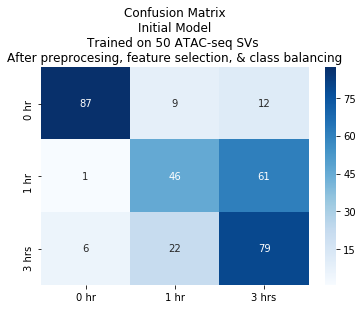

In [126]:
make_confusion_matrix_DEX(Y_atac_test, y_atac_pred, subtitle='Initial Model\nTrained on 50 ATAC-seq SVs \nAfter preprocesing, feature selection, & class balancing')

In [127]:
''' Evaluate model trained ONLY on RNA-seq input '''
y_rna_pred = predict_one_hot(X_rna_test, model_dir='models/best_rnaPCA_upSampled_model')
y_rna_sm = predict(X_rna_test, model_dir='models/best_rnaPCA_upSampled_model')

In [128]:
''' Get metrics for RNA-seq'''
print(f'Accuracy: {accuracy(Y_rna_test, y_rna_pred)}')
print(f'Precision: {precision(Y_rna_test, y_rna_pred)}')
print(f'Recall: {precision(Y_rna_test, y_rna_pred)}')

Accuracy: 0.9566563367843628
Precision: 0.9349845051765442
Recall: 0.9349845051765442


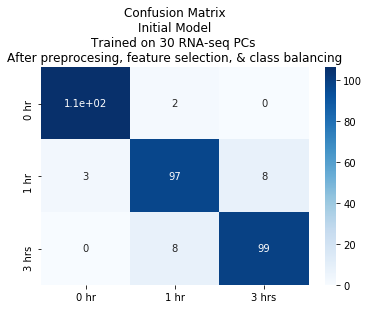

In [129]:
make_confusion_matrix_DEX(Y_rna_test, y_rna_pred, subtitle='Initial Model\nTrained on 30 RNA-seq PCs \nAfter preprocesing, feature selection, & class balancing')

In [39]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bimodal_pred = predict_one_hot(X_bimodal_test, model_dir='models/best_bimodal_cellLoad_upSampled_model')
y_bimodal_sm = predict(X_bimodal_test, model_dir='models/best_bimodal_cellLoad_upSampled_model')

In [46]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bimodal_test, y_bimodal_pred)}')
print(f'Precision: {precision(Y_bimodal_test, y_bimodal_pred)}')
print(f'Recall: {precision(Y_bimodal_test, y_bimodal_pred)}')

Accuracy: 0.5562435388565063
Precision: 0.3343653380870819
Recall: 0.3343653380870819


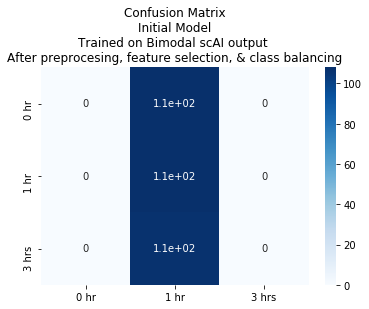

In [47]:
make_confusion_matrix_DEX(Y_bimodal_test, y_bimodal_pred, subtitle='Initial Model\nTrained on Bimodal scAI output \nAfter preprocesing, feature selection, & class balancing')

In [308]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bi_low_pred = predict_one_hot(X_bi_low_test, model_dir='models/best_factor2_model_pp_fs')
y_bi_low_sm = predict(X_bi_low_test, model_dir='models/best_factor2_model_pp_fs')

In [309]:
X_bi_low_train.shape

TensorShape([2376, 2])

In [310]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bi_low_test, y_bi_low_pred)}')
print(f'Precision: {precision(Y_bi_low_test, y_bi_low_pred)}')
print(f'Recall: {precision(Y_bi_low_test, y_bi_low_pred)}')

Accuracy: 0.605031430721283
Precision: 0.4075471758842468
Recall: 0.4075471758842468


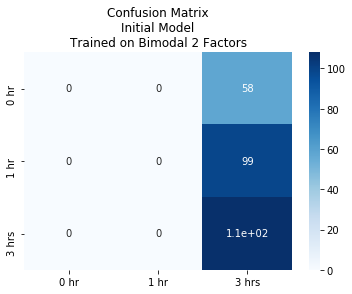

In [311]:
make_confusion_matrix_DEX(Y_bi_low_test, y_bi_low_pred, subtitle='Initial Model\nTrained on Bimodal 2 Factors')

In [50]:
''' Export training and test sets '''
from helpers import *

# create .pkl file names
root = os.getcwd()
pkl_path = os.path.join(root, 'data', 'sci-CAR', 'pkl_files')
pkl_atac = os.path.join(pkl_path, 'atacRaw_upSampled.pkl')
pkl_rna = os.path.join(pkl_path, 'rnaRaw_upSampled.pkl')
pkl_bimodal = os.path.join(pkl_path, 'bimodalRaw_upSampled.pkl')

# pkl_bimodal = os.path.join(pkl_path, 'bimodal_cellLoad_upSampled.pkl')
pkl_bi_low = os.path.join(pkl_path, 'bimodal_cellLoad_upSampled.pkl')

# save training and test sets as pickle files
atac_data = (X_atac_train, X_atac_test, atac_features)
write_zipped_pickle(atac_data, pkl_atac)
print('atac data saved')

rna_data = (X_rna_train, X_rna_test, rna_features)
write_zipped_pickle(rna_data, pkl_rna)
print('rna data saved')

bimodal_data = (X_bimodal_train, X_bimodal_test, bimodal_features)
write_zipped_pickle(bimodal_data, pkl_bimodal)
print('bimodal data saved')

# bi_low_data = (X_bi_low_train, X_bi_low_test, bi_low_features)
# write_zipped_pickle(bi_low_data, pkl_bi_low)
# print('bi_low data saved')

preprocess imported
module name : helpers module package: 
atac data saved
rna data saved
bimodal data saved
